In [ ]:
import pandas as pd
from collections import defaultdict

# Function to calculate k-mer frequencies
def calculate_kmer_frequencies(sequence, k=3):
    kmer_counts = defaultdict(int)
    total_kmers = len(sequence) - k + 1
    for i in range(total_kmers):
        kmer = sequence[i:i+k]
        kmer_counts[kmer] += 1
    kmer_freq = {k: v / total_kmers for k, v in kmer_counts.items()}
    return kmer_freq

# Load the promoter dataset
promoters_df = pd.read_csv('/Users/muthusupriya/Documents/Hareni/sem4/BIO/DATASET/promoters (1).csv')

# Define the value of k
k = 3

# Calculate k-mer frequencies for each sequence
kmer_freq_list = []
for sequence in promoters_df['Sequence']:
    kmer_freq_list.append(calculate_kmer_frequencies(sequence, k))

# Convert list of k-mer frequencies to DataFrame
kmer_freq_df = pd.DataFrame(kmer_freq_list).fillna(0)

# Combine k-mer frequencies with the original promoter dataset
promoters_with_kmer_df = pd.concat([promoters_df, kmer_freq_df], axis=1)

# Save the combined dataset
promoters_with_kmer_df.to_csv('/Users/muthusupriya/Documents/Hareni/sem4/BIO/DATASET/promoters_with_kmer_frequencies.csv', index=False)

import ace_tools as tools; tools.display_dataframe_to_user(name="Promoters with K-mer Frequencies", dataframe=promoters_with_kmer_df)


True


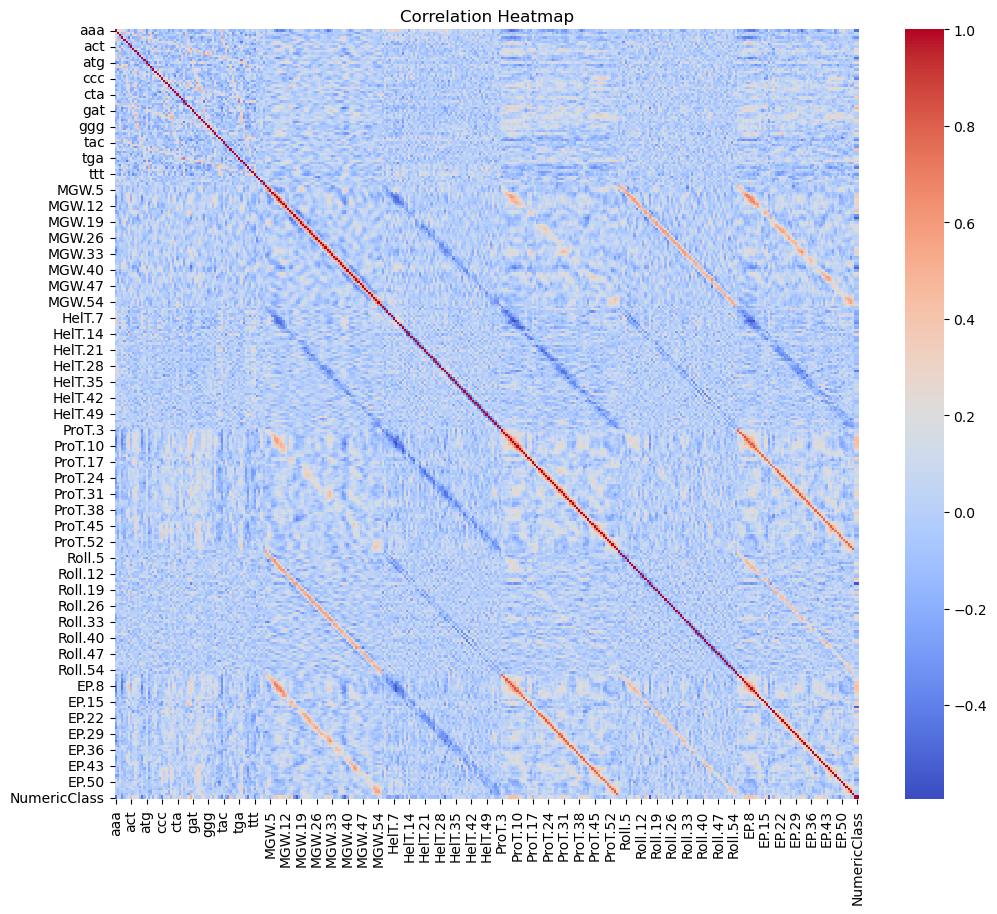

/opt/anaconda3/envs/college/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


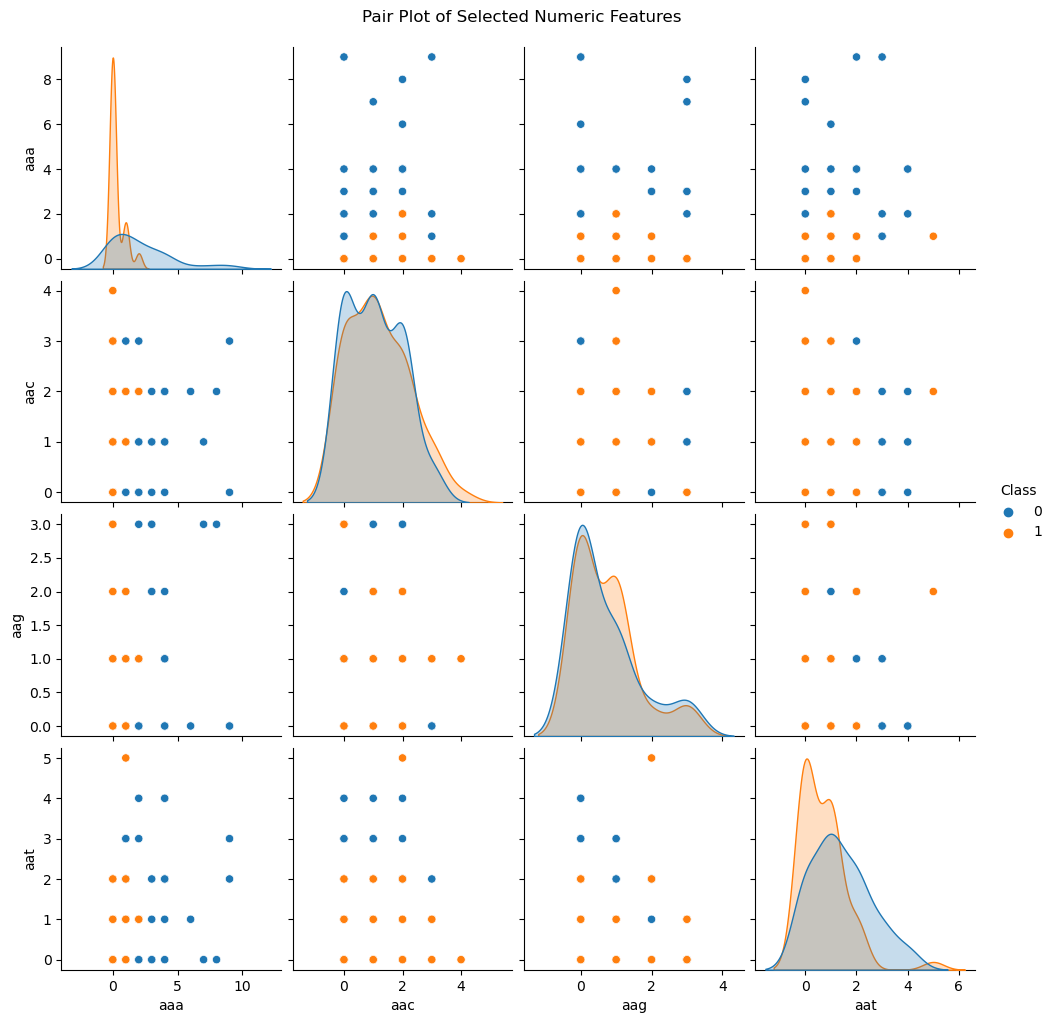

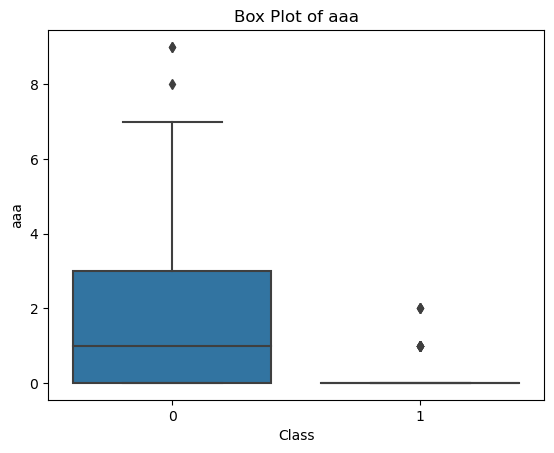

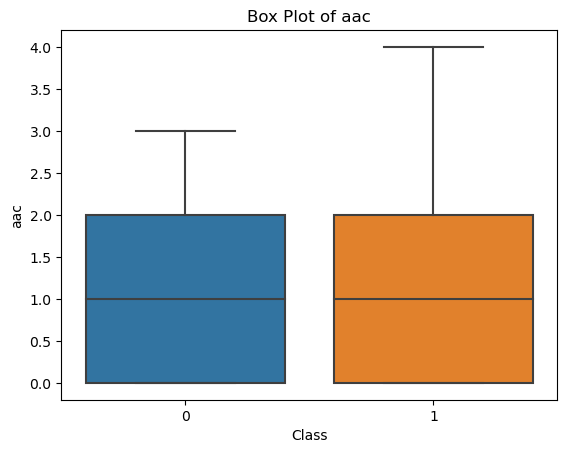

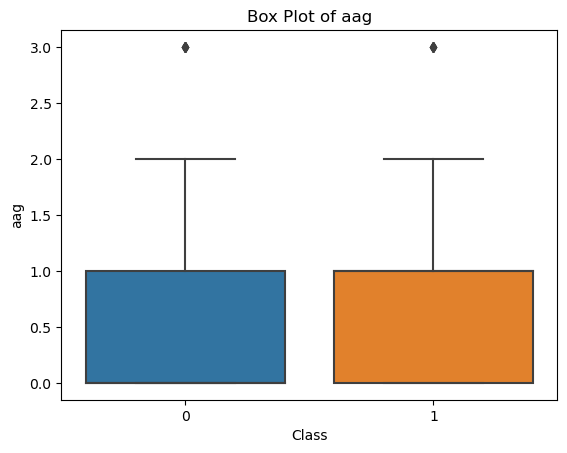

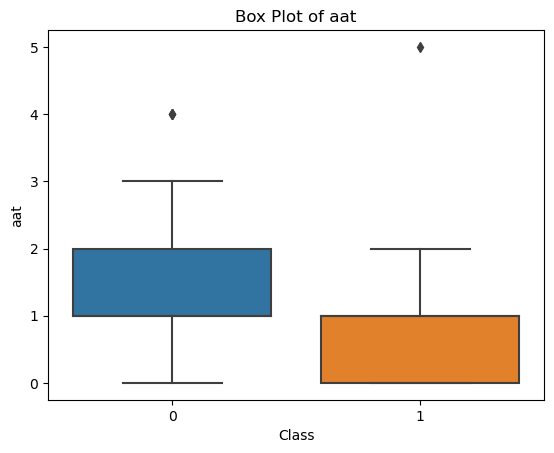

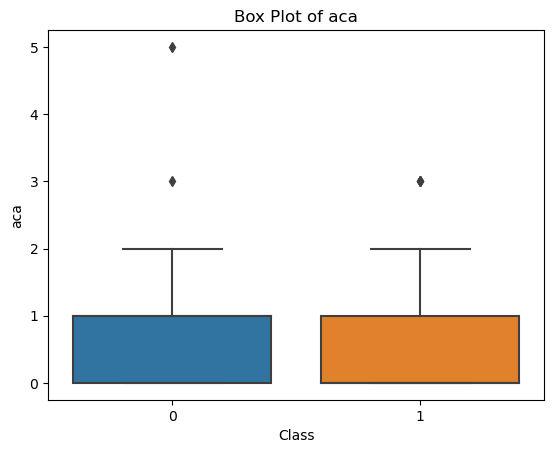

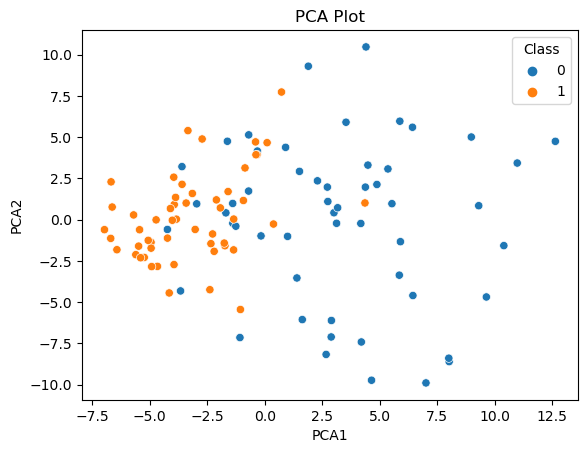

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the data
file_path = '/Users/muthusupriya/Documents/Hareni/sem4/BIO/DATASET/combined_features_with_dna_shapes_imputed.csv'
data = pd.read_csv(file_path)

# Clean up column names
data.columns = data.columns.str.strip()

# Check if 'Class' is correctly formatted and exists
print('Class' in data.columns)  # This should print True if 'Class' is correctly formatted

# Convert 'Class' column to numeric for correlation and PCA, but keep a categorical version for plotting
label_encoder = LabelEncoder()
data['NumericClass'] = label_encoder.fit_transform(data['Class'])
data['Class'] = data['NumericClass'].astype('category')  # Explicitly convert to categorical

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Attempt a pair plot with explicitly categorical 'Class'
try:
    # Using only numeric columns for pairplot to avoid any non-numeric issues
    numeric_cols = data.select_dtypes(include=[float, int]).columns
    sns.pairplot(data[numeric_cols.tolist()[:4] + ['Class']], hue='Class')  # Using first 4 numeric features and 'Class'
    plt.suptitle('Pair Plot of Selected Numeric Features', y=1.02)
    plt.show()
except Exception as e:
    print(f"Error in creating pairplot: {e}")

# Box plots for a few features
features_to_plot = ['aaa', 'aac', 'aag', 'aat', 'aca']
for feature in features_to_plot:
    sns.boxplot(x='Class', y=feature, data=data)
    plt.title(f'Box Plot of {feature}')
    plt.show()

# PCA plot using numeric class
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, :-2])  # Exclude the last two columns (categorical and numeric class)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Class'] = data['Class']
sns.scatterplot(x='PCA1', y='PCA2', hue='Class', data=pca_df)
plt.title('PCA Plot')
plt.show()


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('/Users/muthusupriya/Documents/Hareni/sem4/BIO/DATASET/combined_features_with_dna_shapes_imputed.csv')

# Preprocessing
X = data.drop('Class', axis=1)
y = data['Class']

# Convert '+' and '-' in target to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to tune
models_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf']
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs']
        }
    }
}

# Hyperparameter tuning and evaluation results
# Hyperparameter tuning and evaluation results
results = {}
for name, item in models_params.items():
    clf = GridSearchCV(item['model'], item['params'], cv=5, return_train_score=False)
    clf.fit(X_train_scaled, y_train)
    model = clf.best_estimator_
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = {
        'best_params': clf.best_params_,
        'accuracy': accuracy,
        'classification_report': report
    }

# Print the results
for model_name, model_results in results.items():
    print(f"Results for {model_name}:")
    print("Best Parameters:", model_results['best_params'])
    print("Accuracy:", model_results['accuracy'])
    print("Classification Report:\n", model_results['classification_report'])
    print("\n")


Results for Random Forest:
Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.8636363636363636
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.73      0.84        11

    accuracy                           0.86        22
   macro avg       0.89      0.86      0.86        22
weighted avg       0.89      0.86      0.86        22



Results for SVM:
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.8181818181818182
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.89      0.73      0.80        11

    accuracy                           0.82        22
   macro avg       0.83      0.82      0.82        22
weighted avg       0.83      0.82      0.82        22



Results for Logistic Regression:
Best Parameters: {'C': 0.1, 'sol

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Load the final combined features dataset
final_dataset_path = '/Users/muthusupriya/Documents/Hareni/sem4/BIO/DATASET/combined_features_with_dna_shapes_imputed.csv'
final_dataset = pd.read_csv(final_dataset_path)

# Separate features and target variable
X = final_dataset.drop('Class', axis=1)
y = final_dataset['Class']

# Handle Missing Values using SimpleImputer (if necessary)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_categorical, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define a more simplified CNN model with L2 regularization
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    Flatten(),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

optimizer = Nadam(learning_rate=0.001)

cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add callbacks for early stopping, learning rate reduction, and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)  # Increased patience

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
cnn_model.fit(X_train_cnn, y_train, epochs=500, batch_size=32, 
              validation_data=(X_test_cnn, y_test), callbacks=[reduce_lr, lr_scheduler])

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Test Accuracy: {cnn_accuracy}")

# Generate classification report
y_pred = cnn_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Save the CNN model in the native Keras format
cnn_model.save('/Users/muthusupriya/Documents/Hareni/sem4/BIO/cnn_model.keras')


Epoch 1/500
3/3 [==============================] - 1s 89ms/step - loss: 5.6691 - accuracy: 0.6190 - val_loss: 3.9992 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 23ms/step - loss: 3.8763 - accuracy: 0.8333 - val_loss: 3.9087 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 25ms/step - loss: 3.5436 - accuracy: 0.8690 - val_loss: 3.8187 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 23ms/step - loss: 3.4134 - accuracy: 0.9286 - val_loss: 3.7583 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 22ms/step - loss: 3.2065 - accuracy: 0.9881 - val_loss: 3.6895 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 3.1568 - accuracy: 0.9762 - val_loss: 3.6238 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 23ms/step - loss: 3.0730 - a

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
file_path = '/Users/muthusupriya/Documents/Hareni/sem4/BIO/DATASET/combined_features_with_dna_shapes_imputed.csv'
final_dataset = pd.read_csv(file_path)

# Separate features and target variable
X = final_dataset.drop('Class', axis=1)
y = final_dataset['Class']

# Handle Missing Values using SimpleImputer (if necessary)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Reshape data for LSTM input
X_lstm = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Define an LSTM model with L2 regularization and BatchNormalization
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(32, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01))),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0001)  # Use Adam optimizer with a learning rate of 0.0001
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_lstm.shape[1], 1)
num_classes = y_categorical.shape[1]
lstm_model = create_lstm_model(input_shape, num_classes)

# Add callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model for 500 epochs
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_categorical, test_size=0.2, random_state=42)
lstm_model.fit(X_train, y_train, epochs=500, batch_size=64, 
               validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {lstm_accuracy}")

# Predict the classes for the test set
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print the classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Save the LSTM model in the native Keras format
lstm_model.save('/Users/muthusupriya/Documents/Hareni/sem4/BIO/lstm_model_updated.keras')

Epoch 1/500
2/2 [==============================] - 5s 828ms/step - loss: 4.2422 - accuracy: 0.4762 - val_loss: 3.2860 - val_accuracy: 0.4091 - lr: 1.0000e-04
Epoch 2/500
2/2 [==============================] - 0s 125ms/step - loss: 4.0575 - accuracy: 0.5595 - val_loss: 3.2839 - val_accuracy: 0.4545 - lr: 1.0000e-04
Epoch 3/500
2/2 [==============================] - 0s 124ms/step - loss: 3.8458 - accuracy: 0.4643 - val_loss: 3.2820 - val_accuracy: 0.4545 - lr: 1.0000e-04
Epoch 4/500
2/2 [==============================] - 0s 129ms/step - loss: 3.9584 - accuracy: 0.5238 - val_loss: 3.2800 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/500
2/2 [==============================] - 0s 124ms/step - loss: 4.1730 - accuracy: 0.4524 - val_loss: 3.2781 - val_accuracy: 0.5455 - lr: 1.0000e-04
Epoch 6/500
2/2 [==============================] - 0s 124ms/step - loss: 4.0373 - accuracy: 0.5357 - val_loss: 3.2763 - val_accuracy: 0.5455 - lr: 1.0000e-04
Epoch 7/500
2/2 [==============================] - 0

In [ ]:
import joblib
import tkinter as tk
from tkinter import messagebox

# Define the function to extract k-mers
def get_kmers(sequence, size=4):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

# Load the model and vectorizer
model_path = '/Users/muthusupriya/Documents/Hareni/sem4/BIO/CODE/logisticregression.joblib'
vectorizer_path = '/Users/muthusupriya/Documents/Hareni/sem4/BIO/CODE/vectorizer.joblib'

loaded_model = joblib.load(model_path)
loaded_vectorizer = joblib.load(vectorizer_path)

# Function to predict if a sequence is a promoter region or not
def predict_promoter(sequence):
    sequence_kmers = ' '.join(get_kmers(sequence))
    sequence_vectorized = loaded_vectorizer.transform([sequence_kmers])
    prediction = loaded_model.predict(sequence_vectorized)
    return prediction[0]

# Function to handle prediction and display result
def handle_prediction():
    user_sequence = entry_sequence.get()
    predicted_class = predict_promoter(user_sequence)
    result = "Promoter Region" if predicted_class == 1 else "Non-Promoter Region"
    messagebox.showinfo("Prediction Result", f"The entered sequence is a: {result}")

# Create the main window
root = tk.Tk()
root.title("Promoter Prediction")

# Add a label and entry for the DNA sequence
label_sequence = tk.Label(root, text="Enter DNA Sequence:")
label_sequence.pack(pady=10)

entry_sequence = tk.Entry(root, width=50)
entry_sequence.pack(pady=10)

# Add a button to perform the prediction
button_predict = tk.Button(root, text="Predict", command=handle_prediction)
button_predict.pack(pady=10)

# Run the application
root.mainloop()


: 